## 2020707035 박시언 lab6

### 이번 과제에서는 fetch_20newsgroups 데이터셋을 사용하여 LDA, LSA, BERTopic 세 가지 방법으로 토픽 모델링을 수행했습니다. 
### 데이터셋은 comp.graphics, sci.med, rec.sport.baseball의 세 가지 카테고리로 제한했으며, 텍스트 전처리를 통해 불용어 제거, 소문자 변환, 특수문자 제거, 표제어 추출 등을 진행했습니다.
### LDA는 Gensim 라이브러리를 사용하여 확률 기반으로 주요 키워드를 추출하고, LSA는 TF-IDF 행렬을 기반으로 SVD를 통해 차원을 축소하여 키워드와 문서 분포를 분석했습니다. 
### BERTopic은 Transformer 기반 임베딩을 사용하여 동적으로 토픽을 추출하였습니다.
### 세 모델의 결과는 키워드 품질, 문서 분포 적합성, 모델별 장단점을 기준으로 비교하였으며, 시각화를 통해 각 모델의 토픽 분포를 분석하였습니다.

### LDA: 확률 모델로 토픽별 키워드의 의미적 연관성이 높았으나, 토픽 간 중복이 발생하는 경우가 있었습니다. 학습 시간이 길고 대규모 데이터 처리에 제한적일 수 있습니다.
### LSA: SVD 기반으로 키워드를 추출하였으나, 결과가 명확하지 않고 토픽이 해석하기 어렵다는 한계가 있었습니다. 하지만 계산 속도는 상대적으로 빨랐습니다.
### BERTopic: 동적 토픽 수 설정과 강력한 키워드 추출 능력을 보였으며, 시각화를 통한 문서 분포 분석에서도 뛰어난 성능을 보였습니다. 그러나 임베딩 단계에서 자원이 많이 소모되는 단점이 있었습니다.

In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from sklearn.decomposition import TruncatedSVD, PCA
from bertopic import BERTopic
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import random
import re

# 데이터 준비
categories = ['comp.graphics', 'sci.med', 'rec.sport.baseball']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)
texts = newsgroups.data

[nltk_data] Downloading package punkt to /home/unsi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/unsi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/unsi/anaconda3/envs/forpytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 텍스트 전처리
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

cleaned_texts = [preprocess_text(text) for text in texts]

In [3]:

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(cleaned_texts)

# LDA
tokenized_texts = [text.split() for text in cleaned_texts]
dictionary = Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

lda_model = LdaModel(corpus=corpus, num_topics=3, id2word=dictionary, passes=10)
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]
lda_distributions = np.zeros((len(doc_topics), lda_model.num_topics))
for i, doc in enumerate(doc_topics):
    for topic_id, prob in doc:
        lda_distributions[i, topic_id] = prob

In [4]:

# LSA
svd_model = TruncatedSVD(n_components=3, random_state=42)
X_svd = svd_model.fit_transform(X_tfidf)

In [5]:

# BERTopic
bertopic_model = BERTopic()
topics, probs = bertopic_model.fit_transform(cleaned_texts)

BERTopic probabilities are invalid. Assigning one-hot encoding as fallback.
Detected 34 topics in BERTopic.


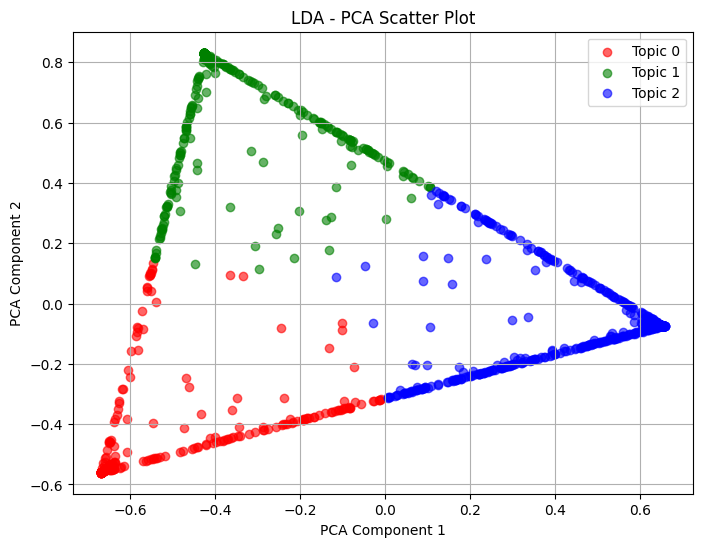

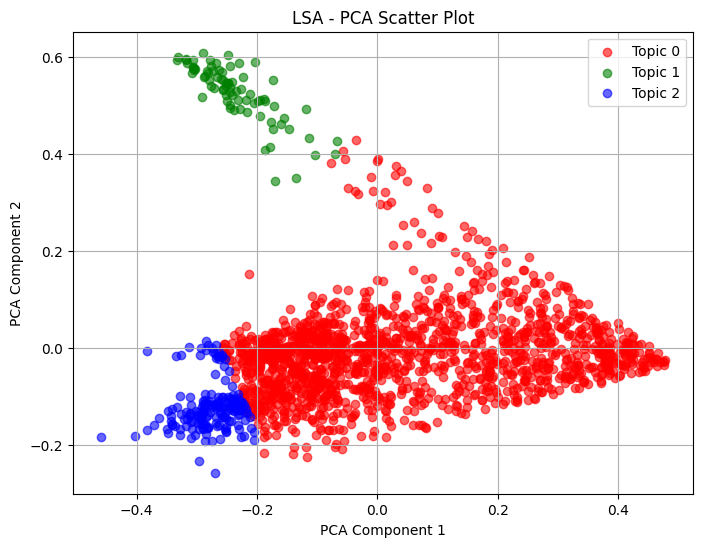

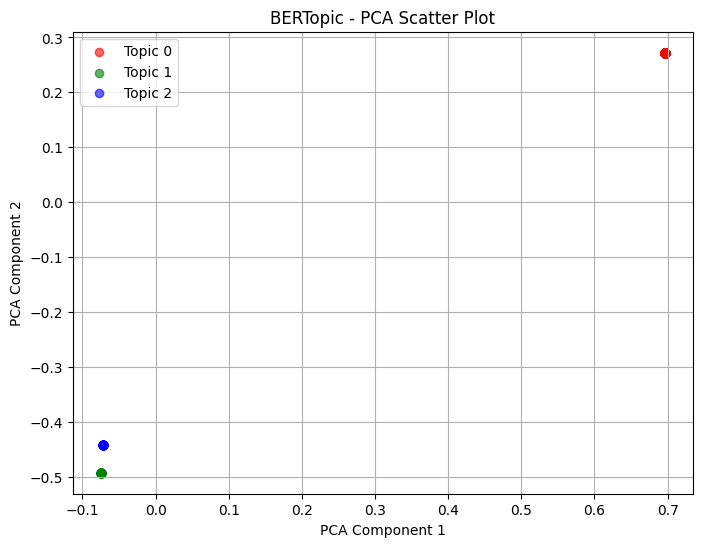

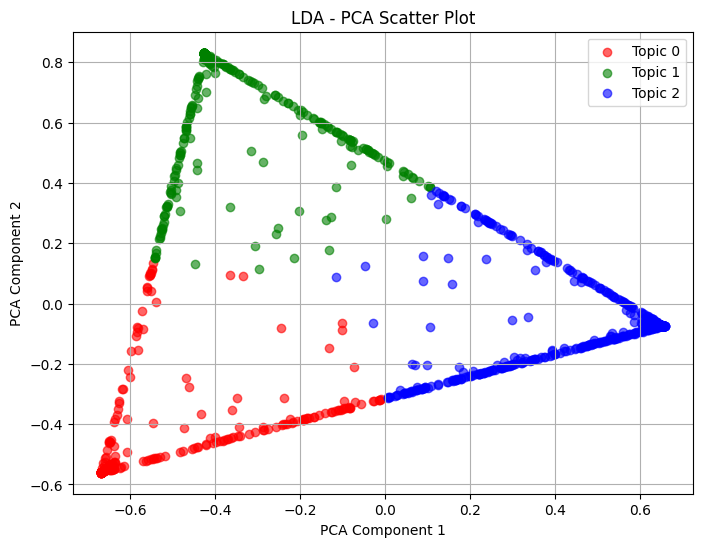

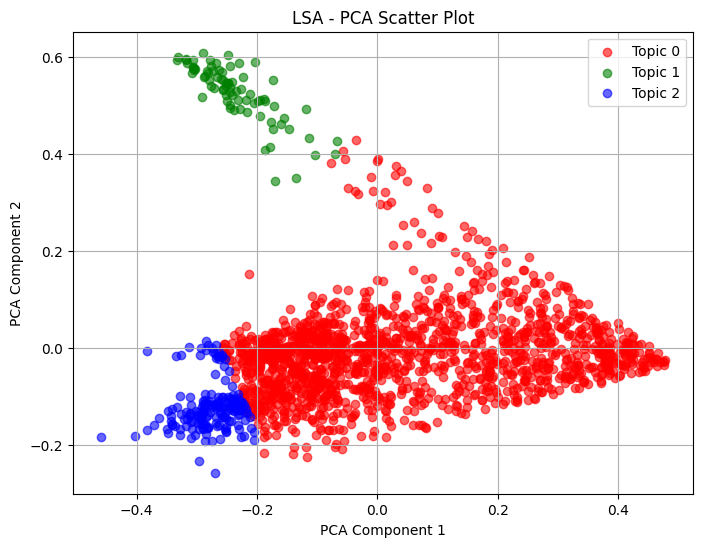

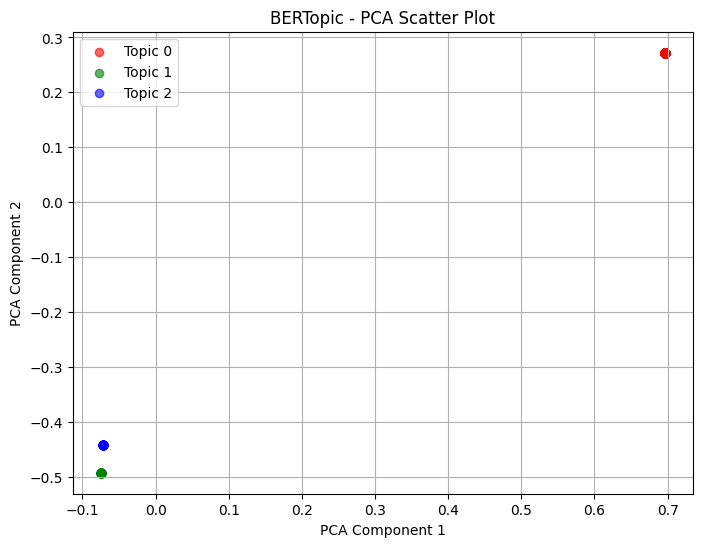

In [6]:

# 확률 분포로 정규화 함수
def normalize_to_distribution(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    return matrix / row_sums

# 각 모델의 결과를 확률 분포 형태로 변환
lsa_distributions = np.abs(X_svd)
lsa_distributions = normalize_to_distribution(lsa_distributions)

# BERTopic 확률 분포 확인 및 처리
if probs is None or len(probs.shape) < 2 or probs.shape[1] < 2:
    print("BERTopic probabilities are invalid. Assigning one-hot encoding as fallback.")
    dominant_topics = np.array(topics)
    num_topics = max(dominant_topics) + 1  # 발견된 토픽 수에 맞게 동적으로 설정
    print(f"Detected {num_topics} topics in BERTopic.")
    probs = np.eye(num_topics)[dominant_topics]
else:
    # probs가 유효하면 확률 분포로 정규화
    probs = normalize_to_distribution(probs)

# PCA 및 시각화 함수
def plot_pca_scatter(model_name, topic_distributions, num_topics=3):
    """
    PCA를 통해 차원 축소 후 문서를 2D scatter plot으로 시각화.
    """
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(topic_distributions)
    plt.figure(figsize=(8, 6))
    colors = ['r', 'g', 'b']
    for i in range(num_topics):
        plt.scatter(
            reduced_data[np.argmax(topic_distributions, axis=1) == i, 0],
            reduced_data[np.argmax(topic_distributions, axis=1) == i, 1],
            label=f"Topic {i}",
            alpha=0.6,
            c=colors[i]
        )
    plt.title(f"{model_name} - PCA Scatter Plot")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid()
    plt.show()

# 각 모델의 결과를 시각화
plot_pca_scatter("LDA", lda_distributions)
plot_pca_scatter("LSA", lsa_distributions)
plot_pca_scatter("BERTopic", probs)


# 각 모델의 결과를 시각화
plot_pca_scatter("LDA", lda_distributions)
plot_pca_scatter("LSA", lsa_distributions)
plot_pca_scatter("BERTopic", probs)